# Clustering lynx

In [4]:
import random
import torch

import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from oml.functional.metrics import calc_cmc, calc_map, calc_precision

In [5]:
# !pip install -U open-metric-learning --user --no-cache-dir
# !pip install gensim --user --no-cache-dir

## Load data

In [6]:
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
data

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3108,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3109,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3110,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3111,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


### Selection of individuals

We are looking for individuals with around 10 images to test the evaluation metrics.

In [7]:
lynx_id_counts = data['lynx_id'].value_counts()
lynx_id_counts[50:70]

F25-069=J1-2019-1388    16
1342                    16
F25-030=B324            15
704                     15
1504                    14
2208                    14
1509                    14
F25-059=1196=1385       14
2446                    14
F39-091=1724            13
1350=B2011              13
1324                    13
F01-055=1363            13
F25-037                 13
1914                    12
2358                    12
2637                    12
Oslo                    12
2778                    12
F25-039                 11
Name: lynx_id, dtype: int64

In [8]:
selected_individuals = ["Oslo", "2778", "1914"]

In [9]:
data_selected_individuals = data[data["lynx_id"].isin(selected_individuals)]
data_selected_individuals = data_selected_individuals.copy()

### Generation of fake 2D image embeddings

In [10]:
def generate_embedding(lynx_id):
    if lynx_id == "Oslo":
        x = random.randint(0, 4)
        y = random.randint(0, 4)
    elif lynx_id == "1914":
        x = random.randint(6, 10)
        y = random.randint(6, 10)
    else:
        x = random.randint(0, 5)
        y = random.randint(5, 10)
        
    return [x, y]

In [11]:
data_selected_individuals["embedding"] = data_selected_individuals["lynx_id"].apply(generate_embedding)

In [12]:
data_selected_individuals[['embedding_x', 'embedding_y']] = pd.DataFrame(data_selected_individuals['embedding'].tolist(), index=data_selected_individuals.index)

In [13]:
data_selected_individuals.reset_index(drop=True, inplace=True)
data_selected_individuals['lynx_id_int'], _ = pd.factorize(data_selected_individuals["lynx_id"])

data_selected_individuals.head()

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height,embedding,embedding_x,embedding_y,lynx_id_int
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-24,NaN,1,0.918,528.90,522.9640,295.95,168.9220,"[3, 3]",3,3,0
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-10-03,NaN,2,0.962,851.85,532.9170,255.90,171.9795,"[3, 1]",3,1,0
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-29,NaN,3,0.977,435.90,486.9813,378.00,244.9369,"[1, 0]",1,0,0
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2019-12-25,NaN,4,0.947,673.95,508.9643,277.95,147.9803,"[0, 1]",0,1,0
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-08-31,NaN,5,0.945,158.88,238.9500,181.92,99.9675,"[4, 2]",4,2,0


### Viewing individuals with their embeddings

Text(0.5, 1.0, 'Scatter plot des embeddings avec coloration par lynx_id')

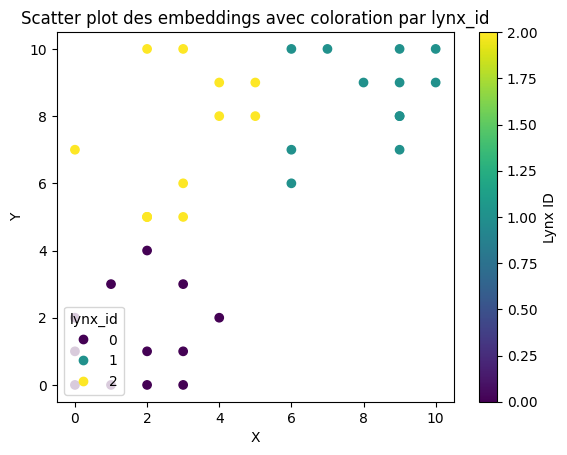

In [14]:
fig, ax = plt.subplots()

scatter = plt.scatter(data_selected_individuals['embedding_x'], data_selected_individuals['embedding_y'], c=data_selected_individuals['lynx_id_int'])

legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="lynx_id")
plt.colorbar(label="Lynx ID")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot des embeddings avec coloration par lynx_id")

## Reception of the image of a new candidate

The image is passed to the model and then we obtain an embedding (here 2D). Now, let's run a search using a candidate and a NearestNeighbors.

In [15]:
candidat_1 = [7, 4]

In [16]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric="minkowski").fit(data_selected_individuals["embedding"].values.tolist())

In [17]:
distances, indices = neighbors.kneighbors([candidat_1])
distances, indices[0]

(array([[2.23606798, 3.16227766, 3.60555128, 3.60555128, 4.12310563]]),
 array([18, 21, 23,  4, 26]))

In [18]:
individual_id = data_selected_individuals.loc[indices[0], "lynx_id"]
individual_id

18    1914
21    1914
23    1914
4     Oslo
26    2778
Name: lynx_id, dtype: object

In [23]:
individual_predicted = individual_id.value_counts().idxmax()
individual_predicted

'1914'

### Compute the metrics

Now let's calculate the metrics. To do this, we use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k**, **mAP@k** and **Precision@k**. 

In [19]:
true_id = "1914"

In [20]:
def acc_k_list(nearest_individuals, true_individual):
    return nearest_individuals.apply(lambda x: x == true_individual).tolist()

In [21]:
gt_tops = torch.tensor([
                        acc_k_list(individual_id, true_id)
], dtype=torch.bool)

n_gt = torch.tensor([5])

top_k=(1,2,3,4,5)

print(gt_tops)
print(n_gt)

tensor([[ True,  True,  True, False, False]])
tensor([5])


#### CMC@k (Cumulative Matching Characteristics) 

In [22]:
calc_cmc(gt_tops, top_k)

[tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.])]

#### mAP@k (mean Average Precision)

In [23]:
calc_map(gt_tops=gt_tops, n_gt=n_gt, top_k=top_k)

[tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.]), tensor([1.])]

#### Precision@k

In [24]:
calc_precision(gt_tops=gt_tops, n_gt=n_gt, top_k=top_k)

[tensor([1.]), tensor([1.]), tensor([1.]), tensor([0.7500]), tensor([0.6000])]

In [24]:
# seuil adaptatif ? (pour différencier nouvel individu d'un existant)
# n_neighbors = nb_impair ne garantit pas d'avoir une solution... si n=5 et qu'il sort 2778, 1914, 1914, Oslo, Oslo que faire ? augmenter le nombre de voisin jusqu'à avoir un vainqueur ?
# de plus, si le meilleur candidat a un seul individu, que faire ?
# le candidat est associé à l'individu le plus proche ou comme un KNN suite à la conclusion avec les N plus proches ? dans ce dernier cas, quelle est la distance ? la moyenne de ces distances ? la distance du plus proche parmi l'individu choisi ?